In [1]:
## Using a custom weight matrix with CUBA example from Brian2 docs

location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

import random
import numpy as np
import matplotlib.pyplot as plt


# recurrent layer
Nn = 4000  # number of neurons in the recurrent layer
W = np.zeros([Nn, Nn])  # matrix of recurrent connection weights, should be a Nn x Nn size array
# W = np.diag(np.ones(Nn)) # -- self connections

def resetw(W=W):
    W = np.zeros([W.shape[0], W.shape[1]])
    return W

# modifying recurrent connection weights as you want to for the network



In [2]:
# %% building a spatially localized connectivity matrix
####################################################

W = resetw()

p_e = 0.2  # probability of e-e connections
p_i = 0.2  # probability of Inh. neurons

Ne = random.sample(range(Nn), int(0.8*Nn))
Ni = [x for x in range(Nn) if x not in Ne]

# need to intersperse E and I neurons throughout the whole cell population
for i in range(Nn):
    # select random indexes to setup as connections based on selected probability
    # set E --> all connectivity
    if i in Ne:
        j = [int(target) for target in np.random.normal(i,200, int(p_e*len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

    # set I --> all connectivity
    elif i in Ni:
        j = [int(target) for target in np.random.normal(i, 200, int(p_i * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]

In [3]:
# Brian2 network

from brian2 import *
from brian2_recurrentnet_seizures.brian2_utils import *

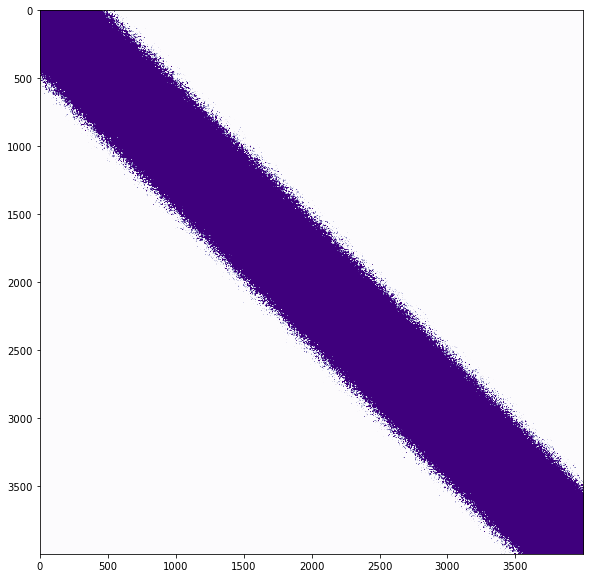

In [4]:
# %% plot connectivity matrix
plot_connectivity_matrix(conn_matrix=W, title=False)

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


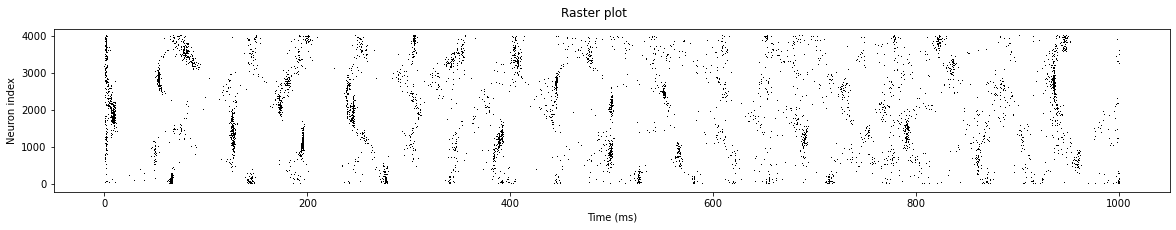

In [5]:
#%% original CUBA model from Brian2
start_scope()

runtime = 1 * second
dt = 0.1*ms

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = """
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
"""

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')

# initialization
P.v = "Vr + rand() * (Vt - Vr)"
# P.v = 'Vr'
P.ge = 0*mV
P.gi = 0*mV

# make synaptic connections and specify the synaptic model
w_e = (60*0.27/10)*mV # excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS
w_i = (-20*4.5/10)*mV # inhibitory synaptic weight


# using custom synaptic connectivity matrix from above
Ce = Synapses(P, P, on_pre='ge += w_e')
i, j = W[Ne].nonzero()
sources = [Ne[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ce.connect(i=sources, j=targets)

Ci = Synapses(P, P, on_pre='gi += w_i')
i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ci.connect(i=sources, j=targets)


trace = StateMonitor(P, 'v', record=[1, 10, 400, 600])
s_mon = SpikeMonitor(P)

run(runtime, report='text')

plot_raster(spike_monitor = s_mon)

collected binned spikes rasters...


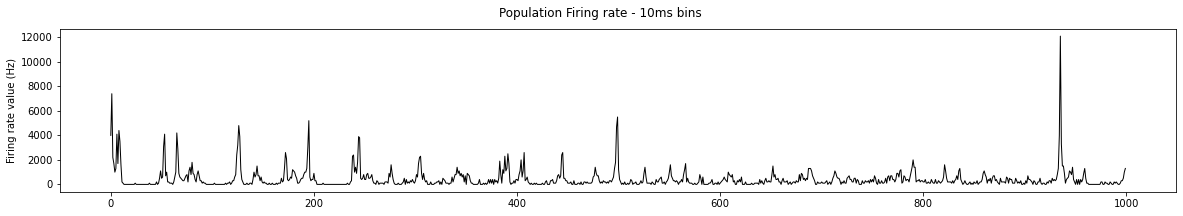

In [9]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

# create numpy array of spikes:
spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=10)
plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate - 10ms bins')

# spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
# plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 100ms bins')

# spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=50)
# plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 50ms bins')



WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


0.006479758293760549


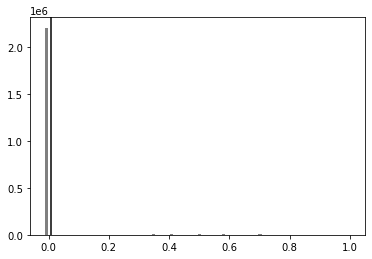

In [10]:
#%% calculate correlation coefficients
corr_mtx = np.corrcoef(spike_raster_binned)
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
# not sure why but there are nan values coming up in the corr_values calculation
# remove nans from corr_values

corr_values = x[~np.isnan(x)]
avg_corr = np.mean(corr_values)
print(np.mean(corr_values))

plt.hist(corr_values, bins=100, color='gray')
plt.axvline(x=avg_corr, color='black')
plt.show()

WARNING    /home/pshah/Documents/code/NeuronalModelling/brian2_recurrentnet_seizures/brian2_utils.py:70: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(range(len(data))), np.log2(data), 'o', label='original data')
 [py.warnings]


n dims: 1000
LinregressResult(slope=-0.6075132056248137, intercept=-4.551399147979956, rvalue=-0.9985839646613904, pvalue=6.4285385701204426e-114, stderr=0.0034500710900167496, intercept_stderr=0.019382587776803347)


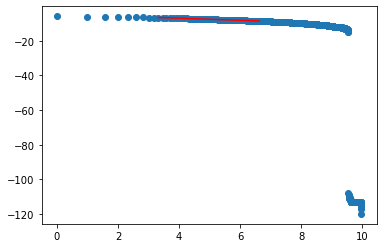

In [11]:
explained_variance_ratio_ = pca_spike_raster(spike_raster_binned)
print("n dims:", len(explained_variance_ratio_))
alpha = powerlawfit(data = explained_variance_ratio_, subset = [10,100])

WARNING    <ipython-input-49-9d8935365203>:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
 [py.warnings]


LinregressResult(slope=-0.4461398643818946, intercept=4.563424768024788, rvalue=-0.9679442021522886, pvalue=8.776943087923266e-306, stderr=0.00514641892348511, intercept_stderr=0.03971937757126838)


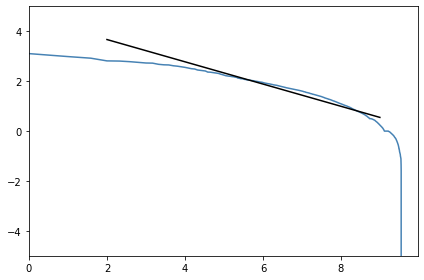

In [49]:
# PCA and powerlaw fit of the eigen decomposition


pca = PCA(n_components=min(spike_raster_binned.shape))
pca.fit(spike_raster_binned)
pca_result = pd.DataFrame(pca.transform(spike_raster_binned))  # , columns=['PCA%i' % i for i in range(275)])
sv = pca.singular_values_
su = (sv / sum(sv))

data = pca.explained_variance_ratio_
data = sv

subset = [2**2,2**9]

# fit and plot variance per PC

x = range(len(data))[subset[0]:subset[1]]
y = data[subset[0]:subset[1]]

# to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
res = stats.linregress(np.log2(x), np.log2(y))
print(res)

x_full = range(len(data))
plt.plot(np.log2(x_full), np.log2(data), label='original data', color='steelblue')
plt.plot(np.log2(x), res.intercept + res.slope * np.log2(x), c = 'black', label='fitted line')
plt.ylim(-5, 5)
plt.margins(x=0)
plt.tight_layout()
plt.show()



In [21]:
print(data[:20])
print(sv[:20])
print(su[:20])

[0.02823049 0.01721978 0.01460355 0.01335342 0.01148787 0.01137594
 0.01099811 0.01056674 0.01021785 0.01013732 0.00949998 0.00924207
 0.00916895 0.00876636 0.00855478 0.00829762 0.00802123 0.00769747
 0.0074349  0.00732199]
[11.03231576  8.61630864  7.93481188  7.58758742  7.03764442  7.00327282
  6.88599277  6.74959841  6.63723416  6.6110279   6.3998359   6.31236511
  6.28734633  6.14776241  6.07311878  5.98114462  5.88068655  5.76078432
  5.6616752   5.61852158]
[0.00736329 0.00575078 0.00529593 0.00506418 0.00469713 0.00467419
 0.00459591 0.00450488 0.00442988 0.00441239 0.00427144 0.00421306
 0.00419636 0.0041032  0.00405338 0.00399199 0.00392494 0.00384492
 0.00377877 0.00374997]


In [29]:
x_full

range(0, 1000)